# Hyperopt Example Notebook - CLI

We recommend using a GPU runtime for this example. In the Colab menu bar, choose Runtime > Change Runtime Type and choose GPU under Hardware Accelerator.

In this notebook, we will show how to use the Ludwig CLI to:

1. Download a Dataset
1. Define Ludwig Model Hyperparameter search
1. Perform Hyperparameter optimization
1. Visualize hyperparameter optimization results

## Install Ludwig
Execute the following command to install Ludwig the components to support hyperparameteroptimization and create visualizations.  The install will take about 1 to 2 minutes.

In [2]:
# Prerequisite: Installs the latest version of Ludwig in the Colab environment
!python -m pip install -U git+https://github.com/ludwig-ai/ludwig.git#"egg=ludwig[hyperopt,viz]" --quiet

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


## Restart the notebook runtime after the Ludwig install completes.
Before continuing , click the following options in the notebook menu at the top: **Runtime** > **Restart runtime**.  Click on the **Yes** button.  Restarting the colab runtime is needed to properly recognize the newly installed software.

Depending on sofware pre-installed in the colab environment, you may see messages like this at the end.  At the time you are running this notebook the package names and versions may vary from below.  Our testing indicates these kinds of messages do not interfere with Ludwig's operation.
```
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.33.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
```

# Download Dataset

[Adult Census Income](https://archive.ics.uci.edu/ml/datasets/adult) is an extract of 1994 Census data for predicting whether a person's income exceeds $50K per year.  The data set consists of over 49K records with 14 attributes with missing data.


The columns in the dataset are

| column         | description                                                  |
|----------------|--------------------------------------------------------------|
| age            | numeric variable, age of person                              |
| workclass      | categorical variable, Type of empolyment                     |
| fnlwgt         | numeric variable, no defintion                               |
| education      | categorical variable, education level                        |
| education-num  | nmeric variable, no definition                               |
| marital-status | categorical variable, marital status                         |
| occupation     | categorical variable, occupation                             |
| relationship   | categorical variable, Relationship to household              |
| race           | categorical variable, race                                   |
| sex            | categorical variable, gender                                 |
| capital-gain   | numeric variable, no definition                              |
| capital-loss   | numeric variable, no definition                              |
| hours-per-week | numeric variable, hours worked per week                      |
| native-country | categorical variable, Country of origin                      |
| income         | binary variable, " <=50K" or " >50K"                         |
| split          | numeric variable, indicating data split training(0), test(2) |


In [18]:
# download data set from the Ludwig Dataset Zoo
!ludwig datasets download adult_census_income

NumExpr defaulting to 8 threads.
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.5.1 - Datasets download



In [19]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv('./adult_census_income.csv')
raw_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,split
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


# Setup for Hyperparameter Optimization

## Define basic Ludwig config 

In [20]:
config_yaml = """
preprocessing:
  number:
    normalization: zscore
    missing_value_strategy: fill_with_mean

input_features:
  - name: age
    type: number
  - name: workclass
    type: category
  - name: fnlwgt
    type: number
  - name: education
    type: category
  - name: education-num
    type: number
  - name: marital-status
    type: category
  - name: occupation
    type: category
  - name: relationship
    type: category
  - name: race
    type: category
  - name: sex
    type: category
  - name: capital-gain
    type: number
  - name: capital-loss
    type: number
  - name: hours-per-week
    type: number
  - name: native-country
    type: category

combiner:
  type: concat
  num_fc_layers: 3
  output_size: 128
  dropout: 0.2

output_features:
  - name: income
    type: binary
    preprocessing:
      fallback_true_label: " >50K"
    num_fc_layers: 4
    output_size: 32

trainer:
  epochs: 10
  optimizer: 
    type: adam
"""

## Hyperparameter Optimization with Random Search

For the Random Serch we will be optimizing over two hyperparameters:

The learning rate used by the Ludwig's Trainer (trainer.learning_rate). The values used will uniformly distributed in the interval 0.001 to 0.01.
The number of fully connected layers used in the income output_feature (income.num_fc_layers). The values will randomly chosen integer in the interval 2 to 8.
The number of random trials will be 16 and is defined by the Executor's num_sample parameter.

Add `hyperopt` section to the Ludwig config yaml and store yaml file to disk.

In [21]:
rs_config_yaml = config_yaml + """
hyperopt:
    executor: 
        type: ray
        num_samples: 16
    goal: maximize
    metric: roc_auc
    output_feature: income
    parameters: 
        income.num_fc_layers: 
            space: randint
            lower: 2
            upper: 9
        trainer.learning_rate:
            space: loguniform
            lower: 0.001
            upper: 0.1
    search_alg:
        type: variant_generator
        random_state: 1919

"""
# Writes config to a file called "rs_config.yaml"
with open("rs_config.yaml", "w") as f:
  f.write(rs_config_yaml)

Code in the following cell will run for 4 to 5 minutes.

In [22]:
# Runs Ludwig hyperopt function
!ludwig hyperopt --dataset adult_census_income.csv \
    --config rs_config.yaml \
    --output_directory rs_output \
    --hyperopt_log_verbosity 1

NumExpr defaulting to 8 threads.
ray.init() failed: Could not find any running Ray instance. Please specify the one to connect to by setting `--address` flag or `RAY_ADDRESS` environment variable.
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.5.1 - Hyperopt

{   'executor': {'num_samples': 16, 'type': 'ray'},
    'goal': 'maximize',
    'metric': 'roc_auc',
    'output_feature': 'income',
    'parameters': {   'income.num_fc_layers': {   'lower': 2,
                                                  'space': 'randint',
                                                  'upper': 9},
                      'trainer.learning_rate': {   'lower': 0.001,
                                                   'space': 'loguniform',
                                                   'upper': 0.1}},
    'search_alg': {'random_state': 1919, 'type': 'variant_generator'},
  

== Status ==
Current time: 2022-05-30 20:08:16 (running for 00:01:29.33)
Memory usage on this node: 3.4/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/7.14 GiB heap, 0.0/3.57 GiB objects
Current best trial: 08d7c_00007 with metric_score=0.9247569441795349 and parameters={'income.num_fc_layers': 2, 'trainer.learning_rate': 0.0022537322252287086}
Result logdir: /opt/project/docs/examples/hyperopt_notebooks/rs_output/trainable_func_fSGGYom
Number of trials: 16/16 (8 PENDING, 8 RUNNING)


== Status ==
Current time: 2022-05-30 20:08:22 (running for 00:01:35.66)
Memory usage on this node: 3.4/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/7.14 GiB heap, 0.0/3.57 GiB objects
Current best trial: 08d7c_00007 with metric_score=0.9262900948524475 and parameters={'income.num_fc_layers': 2, 'trainer.learning_rate': 0.0022537322252287086}
Result logdir: /opt/project/docs/examples/hyperopt_notebooks/rs_output/trainabl

== Status ==
Current time: 2022-05-30 20:09:44 (running for 00:02:57.45)
Memory usage on this node: 3.4/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/7.14 GiB heap, 0.0/3.57 GiB objects
Current best trial: 08d7c_00007 with metric_score=0.9285096526145935 and parameters={'income.num_fc_layers': 2, 'trainer.learning_rate': 0.0022537322252287086}
Result logdir: /opt/project/docs/examples/hyperopt_notebooks/rs_output/trainable_func_fSGGYom
Number of trials: 16/16 (8 RUNNING, 8 TERMINATED)


== Status ==
Current time: 2022-05-30 20:09:50 (running for 00:03:02.78)
Memory usage on this node: 3.4/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/7.14 GiB heap, 0.0/3.57 GiB objects
Current best trial: 08d7c_00007 with metric_score=0.9285096526145935 and parameters={'income.num_fc_layers': 2, 'trainer.learning_rate': 0.0022537322252287086}
Result logdir: /opt/project/docs/examples/hyperopt_notebooks/rs_output/train

Dispaly results of the Random Search Hyperparameter Optimization run.

In [30]:
import json

with open("rs_output/hyperopt_statistics.json", "r") as f:
    hyperopt_results = json.load(f)

df = pd.DataFrame(hyperopt_results["hyperopt_results"])

# display best parameters and metric score
print(f"best hyperparameters: metric score: {df.iloc[0,1]}, hyperparameters: {df.iloc[0,2]}")

best hyperparameters: metric score: 0.9285386800765991, hyperparameters: {'income.num_fc_layers': 4, 'trainer.learning_rate': 0.004893664288146267}


## Hyperparameter Optimization With Grid Search

For Grid Search we specify the points for parameter we want to use.

Trainer's learning rate will be evaluated at 0.001, 0.003, 0.007 and 0.01
The number of fully connected layers for income `output_ feature will be 2, 4, 6 or 8.
The Grid Search algorithm will try all combinations of the hyperparameter values. In this case, the two hyperparameters have 4 possible values so the search will involve  trials.

In this situation we set Executor's num_sample=1 because we only need one run of a particular combination of hyperparameter values.

Add hyperopt section to the Ludwig config yaml and store yaml file to disk.

In [35]:
gs_config_yaml = config_yaml + """
hyperopt:
    executor: 
        type: ray
        num_samples: 1
    goal: maximize
    metric: roc_auc
    output_feature: income
    parameters: 
        income.num_fc_layers: 
            space: grid_search
            values: [2, 4, 6, 8]
        trainer.learning_rate:
            space: grid_search
            values: [0.001, 0.003, 0.007, 0.01]
    search_alg:
        type: variant_generator
        random_state: 1919
"""
# Writes config to a file called "rs_config.yaml"
with open("gs_config.yaml", "w") as f:
  f.write(gs_config_yaml)

In [36]:
# Runs Ludwig hyperopt function
!ludwig hyperopt --dataset adult_census_income.csv \
    --config gs_config.yaml \
    --output_directory gs_output \
    --hyperopt_log_verbosity 1

NumExpr defaulting to 8 threads.
ray.init() failed: Could not find any running Ray instance. Please specify the one to connect to by setting `--address` flag or `RAY_ADDRESS` environment variable.
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.5.1 - Hyperopt

{   'executor': {'num_samples': 1, 'type': 'ray'},
    'goal': 'maximize',
    'metric': 'roc_auc',
    'output_feature': 'income',
    'parameters': {   'income.num_fc_layers': {   'space': 'grid_search',
                                                  'values': [2, 4, 6, 8]},
                      'trainer.learning_rate': {   'space': 'grid_search',
                                                   'values': [   0.001,
                                                                 0.003,
                                                                 0.007,
                                     

== Status ==
Current time: 2022-05-30 20:52:48 (running for 00:01:19.73)
Memory usage on this node: 3.4/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/7.12 GiB heap, 0.0/3.56 GiB objects
Current best trial: 4725c_00005 with metric_score=0.9242293834686279 and parameters={'income.num_fc_layers': 4, 'trainer.learning_rate': 0.003}
Result logdir: /opt/project/docs/examples/hyperopt_notebooks/gs_output/trainable_func_fcI7KFO
Number of trials: 16/16 (8 PENDING, 8 RUNNING)


== Status ==
Current time: 2022-05-30 20:52:54 (running for 00:01:25.65)
Memory usage on this node: 3.4/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/7.12 GiB heap, 0.0/3.56 GiB objects
Current best trial: 4725c_00004 with metric_score=0.9252587556838989 and parameters={'income.num_fc_layers': 2, 'trainer.learning_rate': 0.003}
Result logdir: /opt/project/docs/examples/hyperopt_notebooks/gs_output/trainable_func_fcI7KFO
Number of trials:

== Status ==
Current time: 2022-05-30 20:54:18 (running for 00:02:49.64)
Memory usage on this node: 3.4/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/7.12 GiB heap, 0.0/3.56 GiB objects
Current best trial: 4725c_00006 with metric_score=0.9275208711624146 and parameters={'income.num_fc_layers': 6, 'trainer.learning_rate': 0.003}
Result logdir: /opt/project/docs/examples/hyperopt_notebooks/gs_output/trainable_func_fcI7KFO
Number of trials: 16/16 (8 RUNNING, 8 TERMINATED)


== Status ==
Current time: 2022-05-30 20:54:23 (running for 00:02:54.95)
Memory usage on this node: 3.4/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/7.12 GiB heap, 0.0/3.56 GiB objects
Current best trial: 4725c_00006 with metric_score=0.9275208711624146 and parameters={'income.num_fc_layers': 6, 'trainer.learning_rate': 0.003}
Result logdir: /opt/project/docs/examples/hyperopt_notebooks/gs_output/trainable_func_fcI7KFO
Number of tria

In [37]:
with open("gs_output/hyperopt_statistics.json", "r") as f:
    hyperopt_results = json.load(f)

df = pd.DataFrame(hyperopt_results["hyperopt_results"])

# display best parameters and metric score
print(f"best hyperparameters: metric score: {df.iloc[0,1]}, hyperparameters: {df.iloc[0,2]}")

best hyperparameters: metric score: 0.9275208711624146, hyperparameters: {'income.num_fc_layers': 6, 'trainer.learning_rate': 0.003}


# Visualize Metrics

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt


## ROC Curve

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'


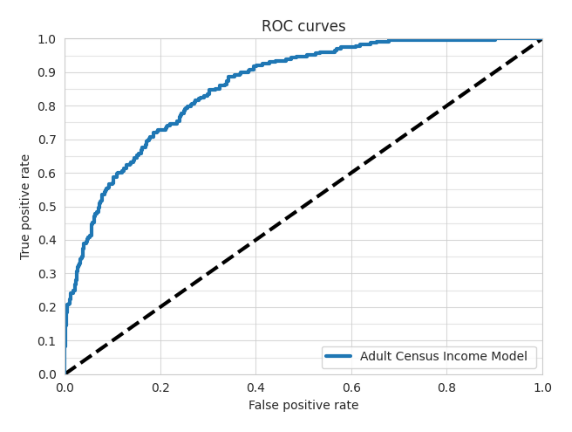

In [11]:
!ludwig visualize --visualization roc_curves \
                  --ground_truth evaluation_dataset.csv \
                  --ground_truth_metadata results/experiment_run/model/training_set_metadata.json \
                  --probabilities test_results/predictions.parquet \
                  --output_feature_name income \
                  --output_directory visualizations \
                  --model_names "Adult Census Income Model" \
                  --file_format png

# retrieve the generated plot to display
fig, ax = plt.subplots(figsize=(10,14))
plt.imshow(plt.imread("visualizations/roc_curves.png"))
ax.axis("off")
plt.show()

## Binary Threshold Metrics

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'


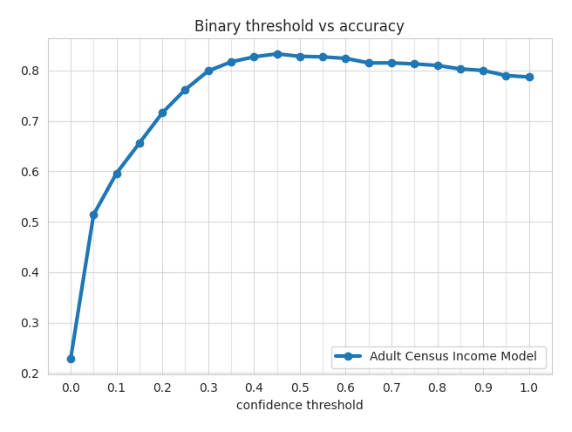

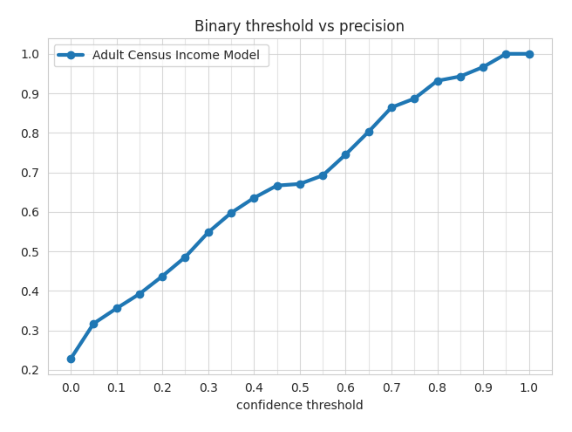

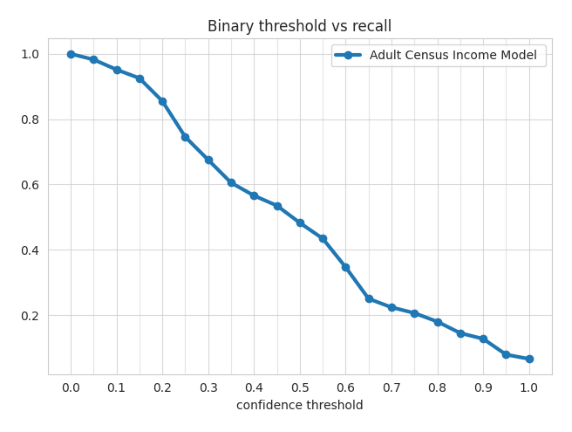

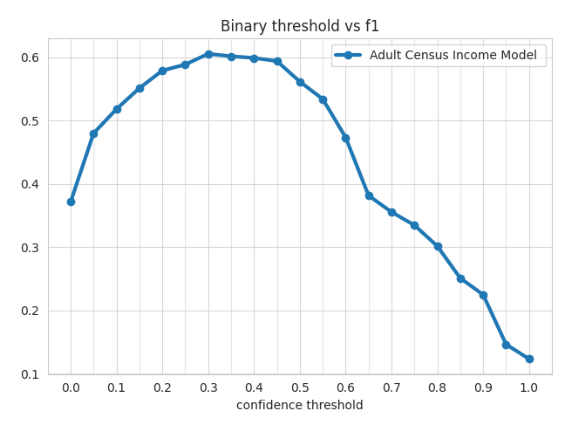

In [12]:
!ludwig visualize --visualization binary_threshold_vs_metric \
                  --ground_truth evaluation_dataset.csv \
                  --ground_truth_metadata results/experiment_run/model/training_set_metadata.json \
                  --probabilities test_results/predictions.parquet \
                  --output_feature_name income \
                  --positive_label 1 \
                  --output_directory visualizations \
                  --model_names "Adult Census Income Model" \
                  --metrics accuracy precision recall f1\
                  --file_format png

# retrieve the generated plot to display
plot_fps = ["visualizations/binary_threshold_vs_metric_accuracy.png",
            "visualizations/binary_threshold_vs_metric_precision.png",
            "visualizations/binary_threshold_vs_metric_recall.png",
            "visualizations/binary_threshold_vs_metric_f1.png"]
for plot_fp in plot_fps:
  fig, ax = plt.subplots(figsize=(10,14))
  plt.imshow(plt.imread(plot_fp))
  ax.axis("off")
  plt.show()

# Predictions

In [14]:
!ludwig predict --model_path results/experiment_run/model \
                --dataset evaluation_dataset.csv \
                --output_directory predictions

NumExpr defaulting to 2 threads.
import ray failed with exception: No module named 'ray'
███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.5rc2 - Predict

Dataset path: evaluation_dataset.csv
Model path: results/experiment_run/model

  embedding_size (50) is greater than vocab_size (10). Setting embedding size to be equal to vocab_size.
  embedding_size (50) is greater than vocab_size (17). Setting embedding size to be equal to vocab_size.
  embedding_size (50) is greater than vocab_size (8). Setting embedding size to be equal to vocab_size.
  embedding_size (50) is greater than vocab_size (16). Setting embedding size to be equal to vocab_size.
  embedding_size (50) is greater than vocab_size (7). Setting embedding size to be equal to vocab_size.
  embedding_size (50) is greater than vocab_size (6). Setting embedding size to be equal to vocab_size.
  embedding

In [16]:
# display sample predictions
predictions = pd.read_parquet("predictions/predictions.parquet")
predictions.head()

,income_probabilities,income_predictions,income_probabilities_ <=50K,income_probabilities_ >50K,income_probability
0,"[0.418786883354187, 0.581213116645813]",>50K,0.418787,0.581213,0.581213
1,"[0.7777636051177979, 0.22223639488220215]",<=50K,0.777764,0.222236,0.777764
2,"[0.7645255476236343, 0.23547445237636566]",<=50K,0.764526,0.235474,0.764526
3,"[0.9857321968302131, 0.01426780316978693]",<=50K,0.985732,0.014268,0.985732
4,"[0.988319487310946, 0.011680512689054012]",<=50K,0.988319,0.011681,0.988319
